In [1]:
#This script produces visualizations of the calibrated neural likelihood surfaces with 95% approximate confidence regions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as patch_polygon

In [2]:
#Load calibrated neural likelihood surfaces
image_size = 25
image_name = str(image_size) + "_by_" + str(image_size)
local_folder = "/home/juliatest/Dropbox/likelihood_free_inference/neural_likelihood/brown_resnick"
version = "final_version"
calibrated_neural_likelihood_surfaces_file =(local_folder + "/evaluate_nn/produce_neural_likelihood_surfaces/data/" + image_name
                                        + "/" + version + "/calibrated/single/reps/200/"
                                        "/calibrated_neural_likelihood_surfaces_9_by_9_density_25_by_25_image_200.npy")
calibrated_neural_likelihood_surfaces = np.load(calibrated_neural_likelihood_surfaces_file)

number_of_parameters = 81
number_of_reps = 200
#first column is range and second is smooth
parameter_matrix = np.load((local_folder + "/evaluate_nn/generate_data/data/" + image_name + 
                            "/single/reps/200/evaluation_parameters_9_by_9_density_" + image_name + "_200.npy"))

possible_ranges = [round(.05*i,2) for i in range(1, 41)]
possible_smooths = [round(.05*i,2) for i in range(1, 41)]
#Cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom (dimension of parameter space)
C = 5.99

In [3]:
#This function produces the 95 percent approximate confidence region over the parameter grid for a given neural likelihood surface
    #parameters:
        #neural_likelihood_surface: 40 by 40 matrix, neural likelihood surface for a given realization of the BR
            #(uncalibrated or calibrated)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooths on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom 
            #(dimension of parameter space)
def produce_neural_likelihood_confidence_region(neural_likelihood_surface, possible_ranges, possible_smooths, C):

    max_field_value = np.log(np.max(neural_likelihood_surface))
    field_difference = 2*(max_field_value - np.log(neural_likelihood_surface))
    confidence_grid = np.where(field_difference <= C, 1, 0)

    smooth_values = []
    range_values = []
    
    for i in range(0, confidence_grid.shape[0]):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            #min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            max_val = (np.array(np.where((confidence_grid[i,:]) == 1))).max()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[max_val])

    for i in range((confidence_grid.shape[0] - 1), 0, -1):
        if(np.array(np.where((confidence_grid[i,:]) == 1)).any()):
            min_val = (np.array(np.where((confidence_grid[i,:]) == 1))).min()
            smooth_values.append(possible_smooths[i])
            range_values.append(possible_ranges[min_val])

    confidence_region = np.zeros((len(smooth_values),2))
    confidence_region[:,0] = range_values
    confidence_region[:,1] = smooth_values

    return confidence_region

#Produce visualization of neural likelihood surface with 95 percent approximate confidence region
    #parameters:
        #neural_likelihood_surface: 40 by 40 matrix, neural likelihood surface for a given realization of the BR
            # (calibrated or uncalibrated)
        #possible_ranges: values of ranges on the parameter grid
        #possible_smooths: values of smooth on the parameter grid
        #C: cut off value that corresponds to 95 percent coverage for chi-distribution with 2 degrees of freedom
            #(dimension of parameter space)
        #true_range: the range value which generated the realization of the BR
        #true_smooth: the smooth value which generated the realization of the BR
        #irep: the number referring to the specific realization for the given parameter on the grid
        #constant: the color scale for the visualization is set to span the maximum value of the surface and ten units less than 
            #the maximum value of the surface
def produce_neural_confidence_region_surface(neural_likelihood_surface, possible_ranges, possible_smooths, C, 
                                             true_range, true_smooth, irep, constant):

    confidence_region = produce_neural_likelihood_confidence_region(neural_likelihood_surface, possible_ranges, possible_smooths, C)
    polygon_figure = patch_polygon(confidence_region, facecolor = "none", edgecolor = "black", linewidth = 5)
    fig, ax = plt.subplots(figsize = (10,10))
    x = np.linspace(.05, 2, 40)
    y = np.linspace(.05, 2, 40)
    X, Y = np.meshgrid(x, y)
    neural_likelihood_surface[neural_likelihood_surface == np.inf] == np.min(neural_likelihood_surface[neural_likelihood_surface != np.inf])
    Z = np.log(neural_likelihood_surface)
    Z = Z.reshape((40, 40))
    max_indices = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    max_range = possible_ranges[max_indices[0]]
    max_smooth = possible_smooths[max_indices[1]]
    cp = ax.contourf(X, Y, Z, vmin = (np.amax(Z) -constant), vmax = np.amax(Z), levels = 12000)
    ax.add_patch(polygon_figure)
    ax.scatter(true_smooth, true_range, s = 600, marker = "*", c = "black")
    ax.scatter(max_smooth, max_range, s = 600, marker = "o", c= "red")
    legend_elements = [Line2D([0], [0], marker='*', color='w', label='True',
                          markerfacecolor='black', markersize=40), 
                          Line2D([0], [0], marker='o', color='w', label='Estimate',
                          markerfacecolor='red', markersize=30), Line2D([0], [0], marker='_', color='black', label='95% CR',
                          markerfacecolor='none', markersize=40, linewidth = 8)]
    ax.legend(handles = legend_elements, facecolor='white', framealpha=1, fontsize="25")
    ax.set_xlabel("smooth", fontsize = 40)
    ax.set_ylabel("range", fontsize = 40)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize =20)
    plt.title("Neural Likelihood", fontsize = 45)
    plt.tight_layout()
    fig_name = (local_folder + 
                "/evaluate_nn/visualizations/visualize_approximate_confidence_regions/visualizations/neural_likelihood/" + 
                version + "/calibrated/single/reps/200/" 
                + str(constant) + "_calibrated_neural_likelihood_approximate_confidence_region_95_smooth_" + 
                str(round(true_smooth, 2))
     + "_range_" + str(round(true_range, 2)) + "_rep_" + str(irep) + ".png")
    plt.savefig(fig_name)

Locator attempting to generate 10468 ticks ([-7.287, ..., 3.1800000000000006]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10779 ticks ([-7.287, ..., 3.4910000000000005]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10630 ticks ([-7.287, ..., 3.3419999999999996]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10972 ticks ([-7.287, ..., 3.684]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 11011 ticks ([-7.287, ..., 3.723]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10833 ticks ([-7.287, ..., 3.545000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10916 ticks ([-7.287, ..., 3.628000000000001]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10675 ticks ([-7.287, ..., 3.3869999999999996]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 10939 ticks ([-7.287, ..., 3.6510000000000007

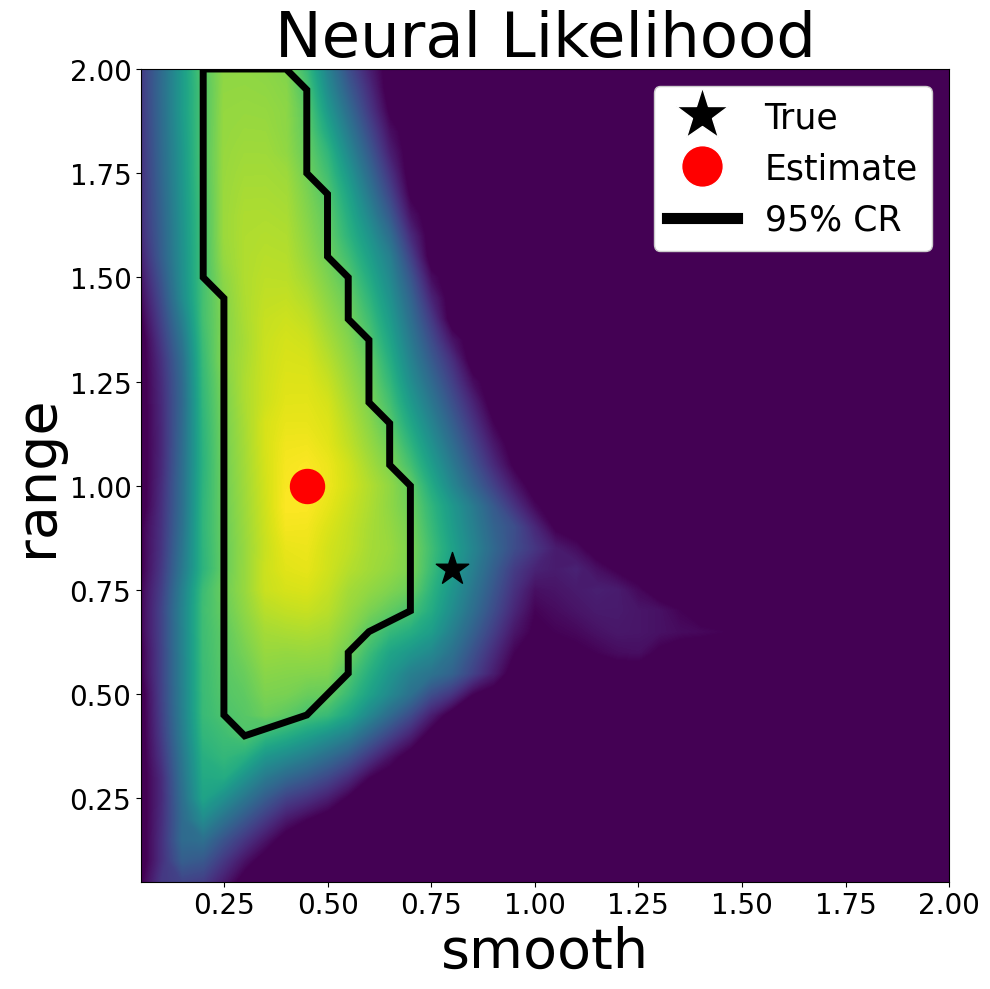

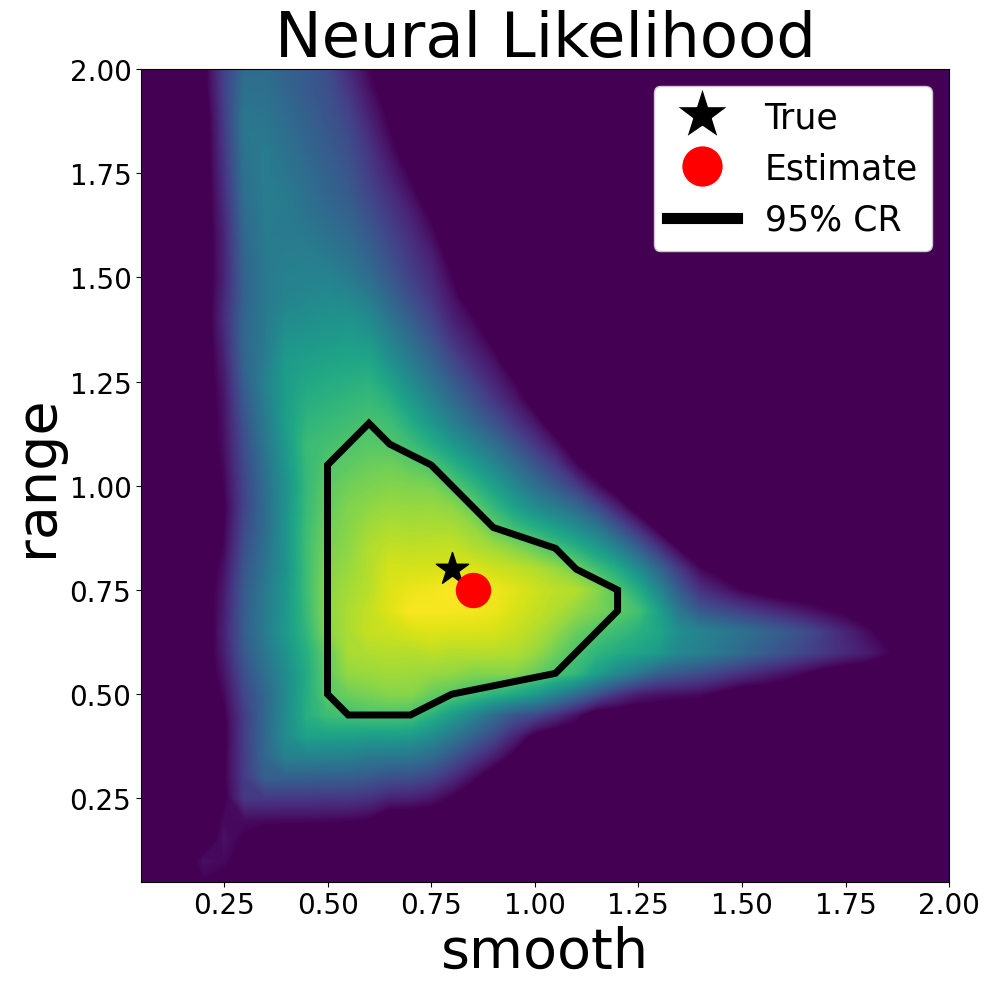

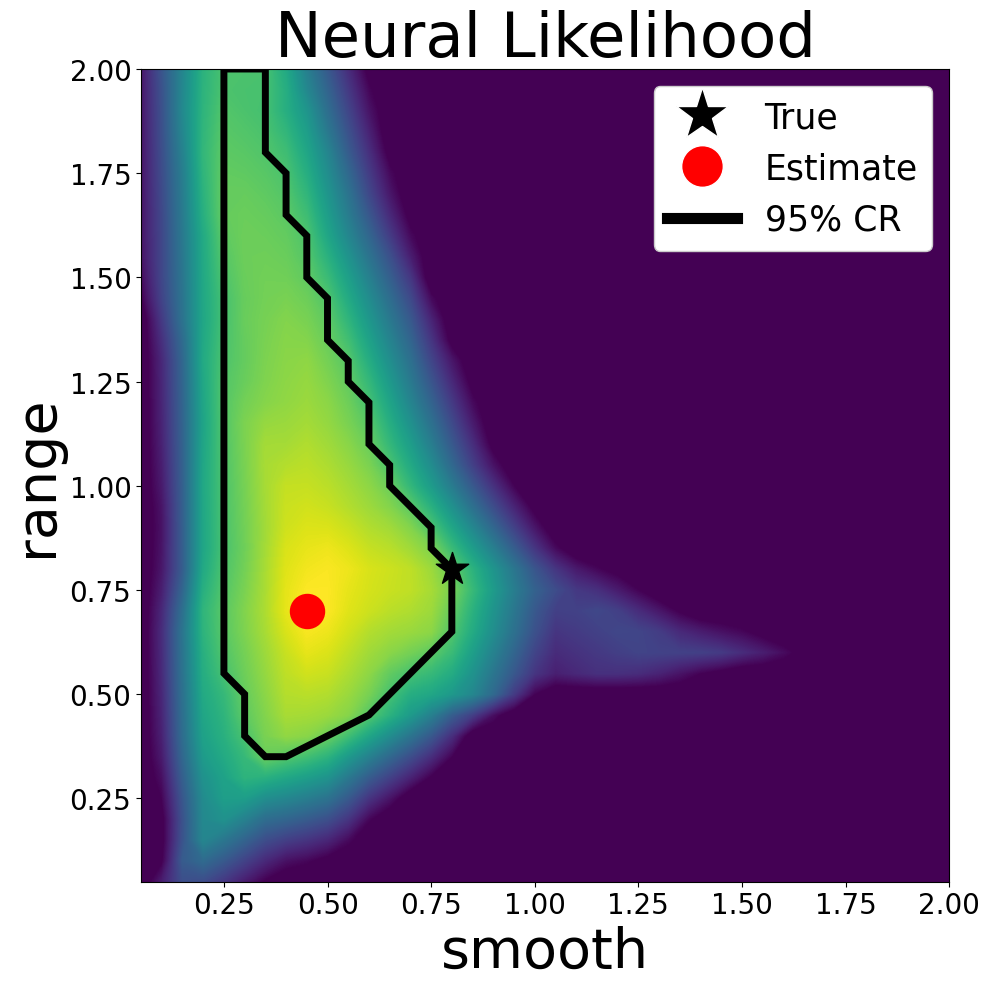

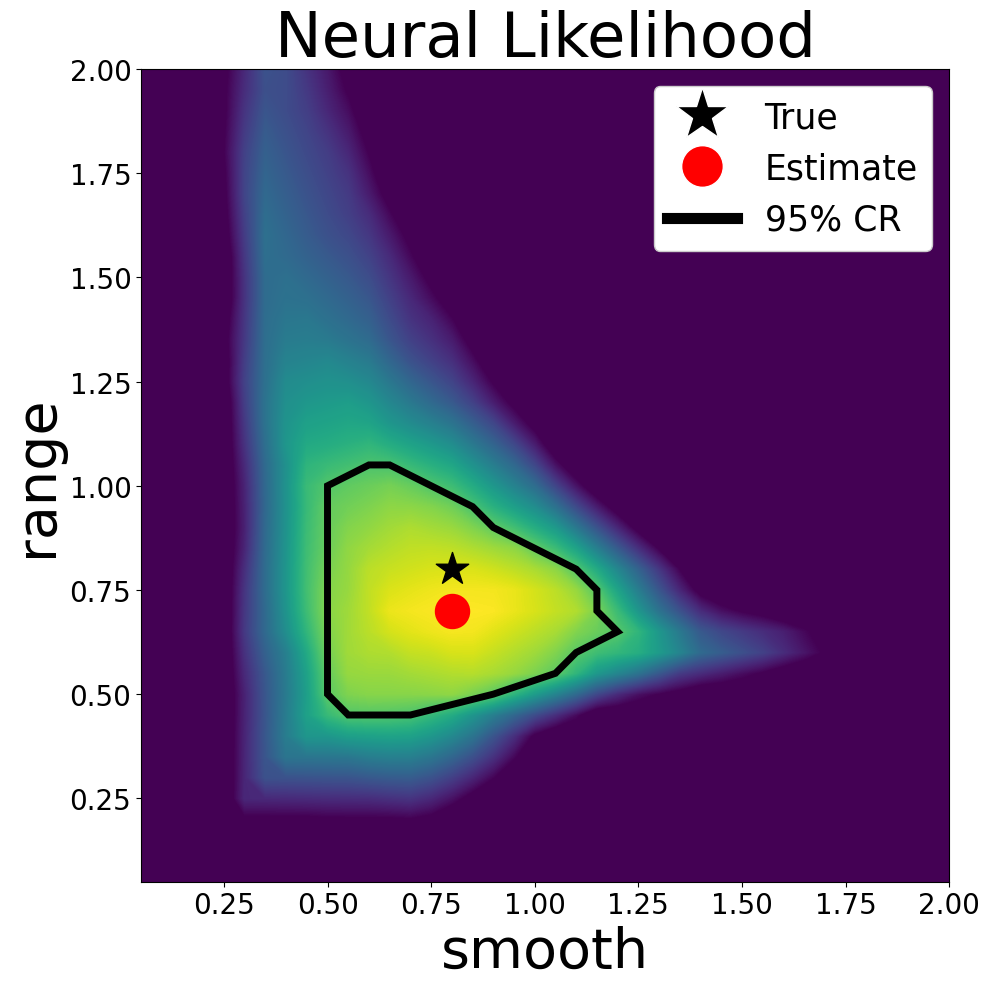

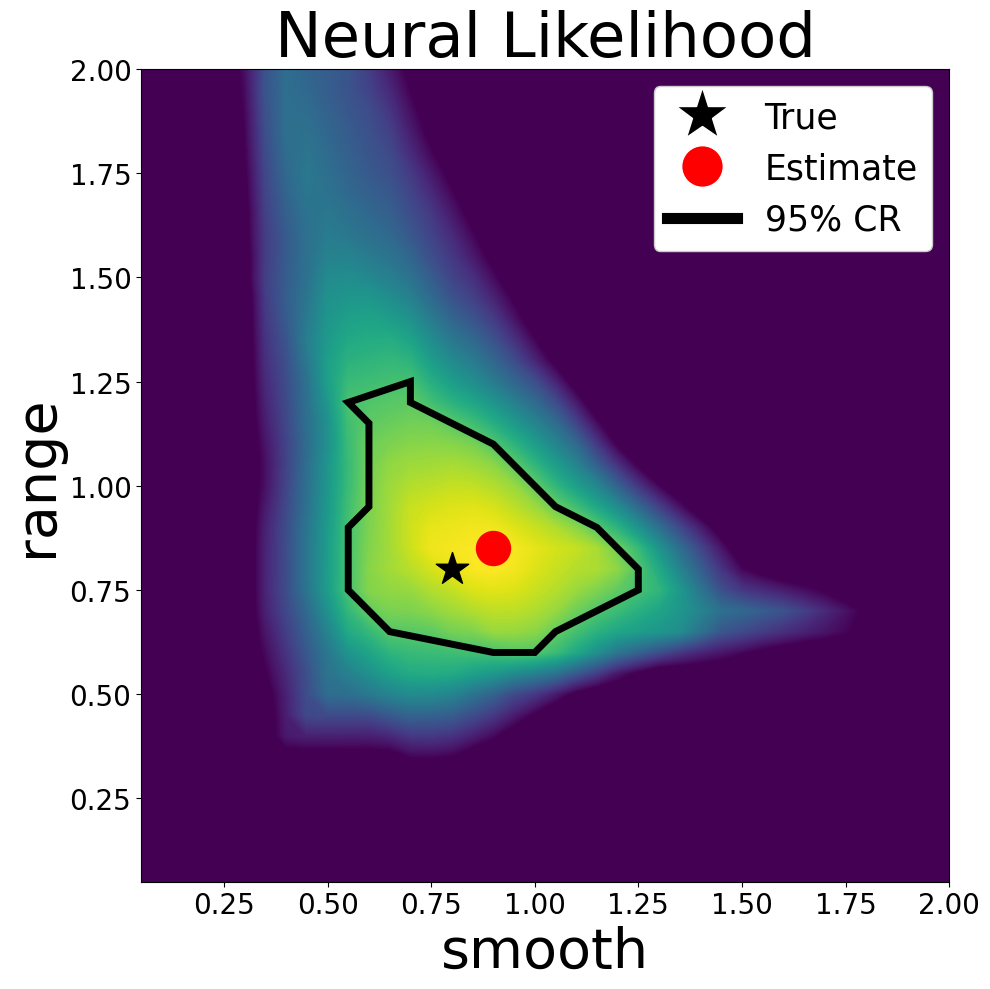

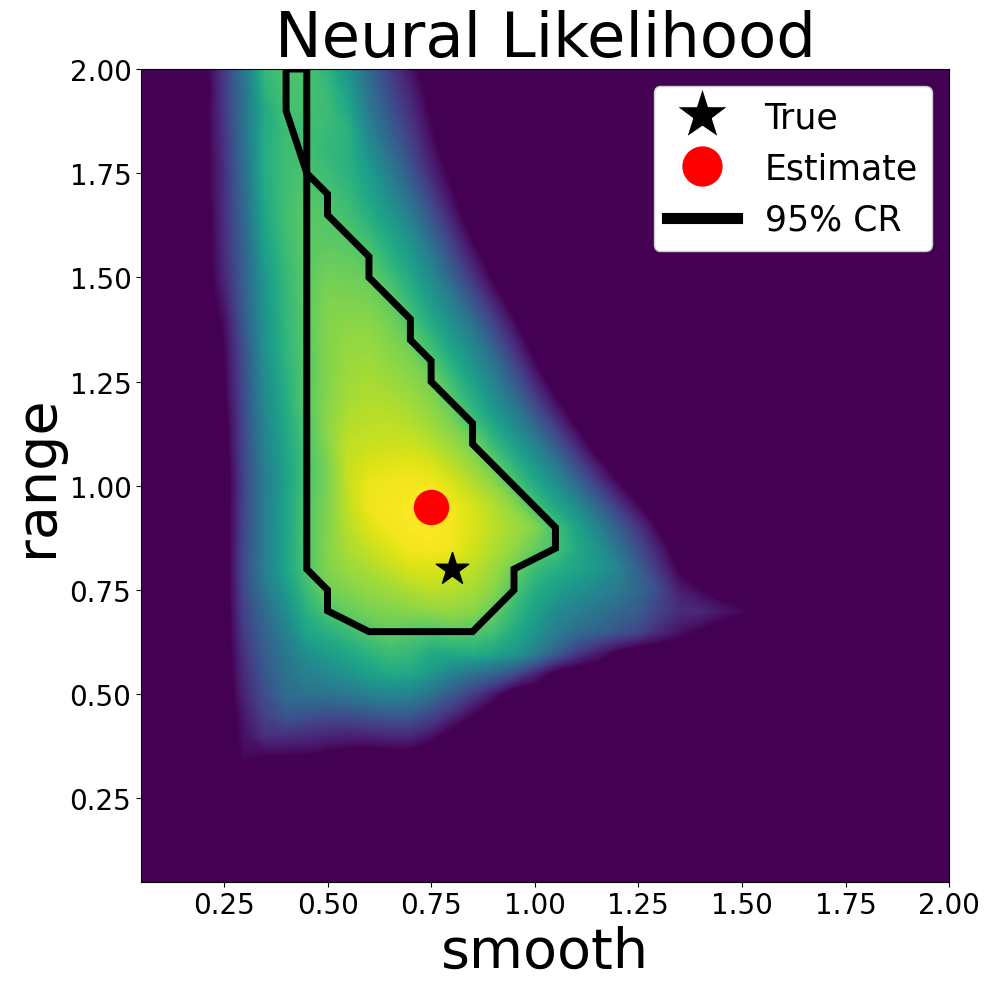

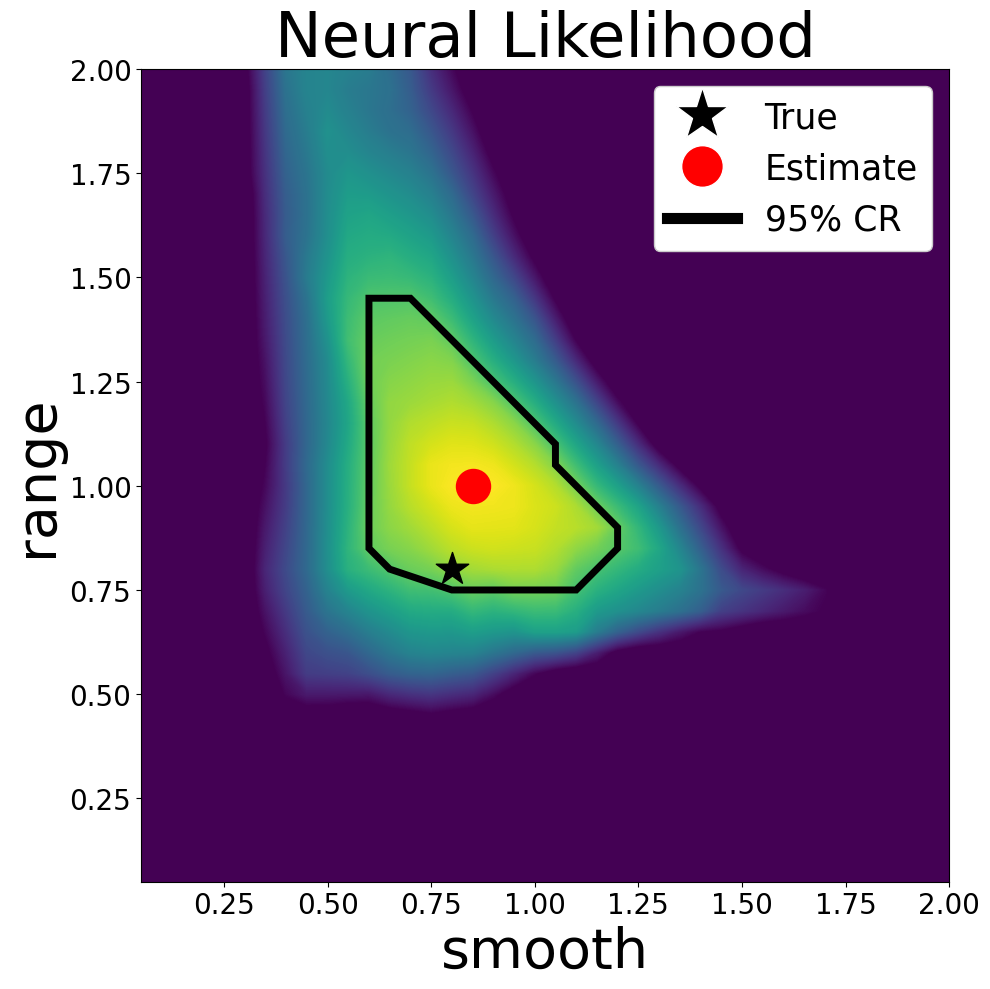

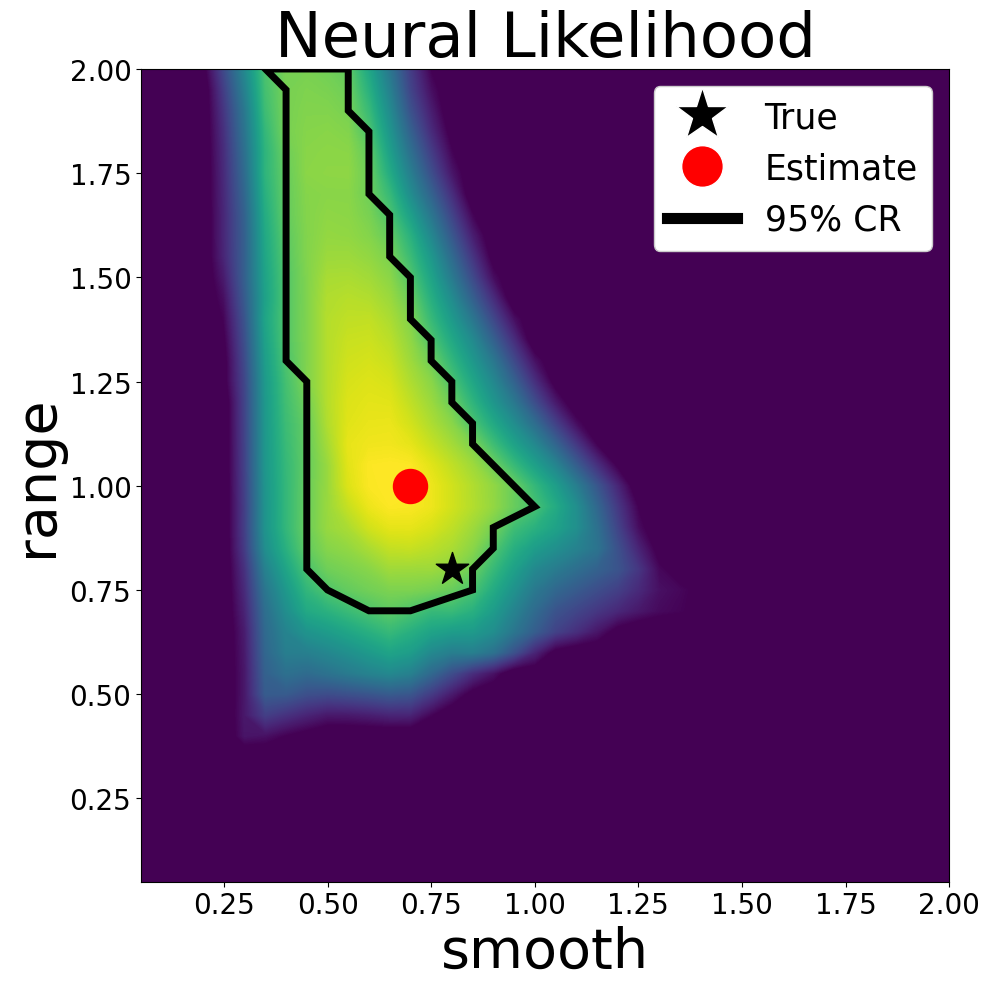

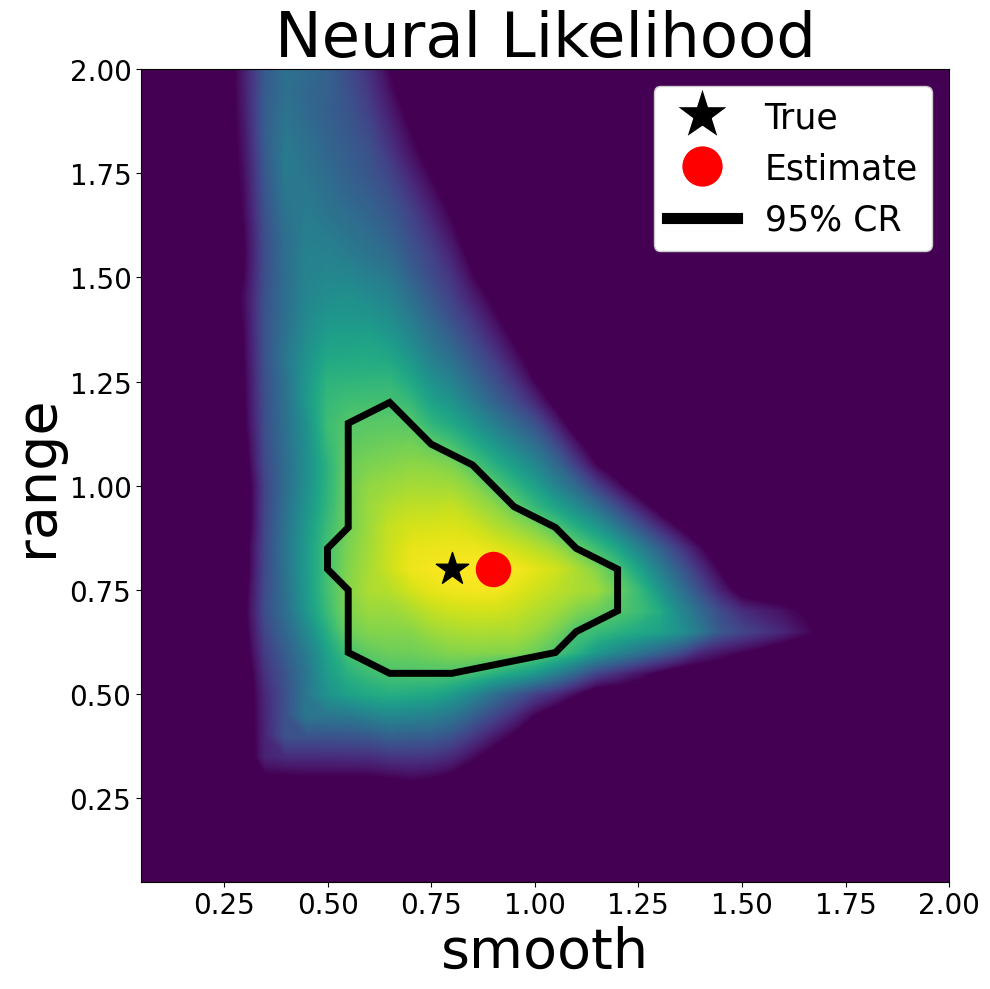

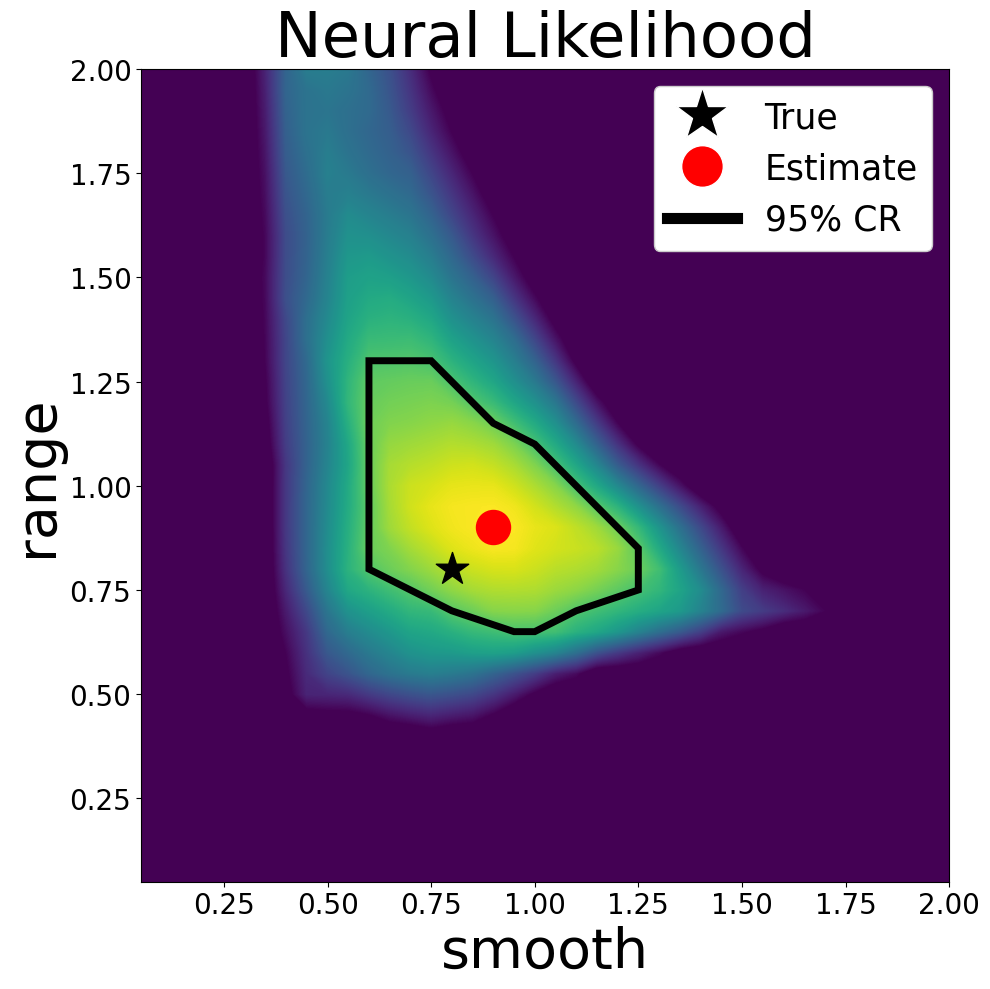

In [5]:
#These are the indices for the 4 by 4 grid over the parameter space starting at (.4,.4) and increasing by increments of .4
indices = [10,12,14,16,28,30,32,34,46,48,50,52,64,66,68,70]
constant = 10

for ipred in [30]:
    for irep in range(0,10):
        #first column is variance
        current_range = parameter_matrix[ipred,0]
        current_smooth = parameter_matrix[ipred,1]
        produce_neural_confidence_region_surface(calibrated_neural_likelihood_surfaces[ipred, irep,:,:], 
                                                 possible_ranges, possible_smooths, C, current_range, 
                                                 current_smooth, irep, constant)